# data-summary-2.ipynb

## 0. Import the necessary libraries

In [206]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import plotly.graph_objs as go
from scipy import stats
import seaborn as sns
import rasterio
from rasterio.mask import mask
from shapely.geometry import box

## 1. Preview of the dataset

In [207]:
d = os.path.dirname(os.path.dirname(os.path.abspath('.gitignore')))
datasets_dir = d + '/datasets/'
output_dir = d + '/data-summary/'

# adjusting display options to make sure all columns are visible and up to 100 rows can be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

df_cities = pd.read_csv(datasets_dir + '/berkeley-earth-surface-temp-dataset/GlobalLandTemperaturesByCity.csv')

df_tw = df_cities[df_cities["Country"] == "Taiwan"]

# preview of the dataset
print(df_tw.head())

                 dt  AverageTemperature  AverageTemperatureUncertainty  \
1611881  1841-01-01              13.108                          2.519   
1611882  1841-02-01              13.234                          1.908   
1611883  1841-03-01              14.386                          2.383   
1611884  1841-04-01              18.287                          2.057   
1611885  1841-05-01              22.627                          1.423   

            City Country Latitude Longitude  
1611881  Chungho  Taiwan   24.92N   120.59E  
1611882  Chungho  Taiwan   24.92N   120.59E  
1611883  Chungho  Taiwan   24.92N   120.59E  
1611884  Chungho  Taiwan   24.92N   120.59E  
1611885  Chungho  Taiwan   24.92N   120.59E  


### 1.1. Shape of the dataset

In [208]:
# shape of the dataset
print(f'No. of Samples: {df_tw.shape[0]} - No. of Features: {df_tw.shape[1]}')

No. of Samples: 62190 - No. of Features: 7


### 1.2. Number of records per city

In [209]:
# number of records per city (30 cities in total)
print(df_tw['City'].value_counts())

City
Chungho      2073
Chupei       2073
Yungho       2073
Yangmei      2073
Yüanlin      2073
Tucheng      2073
Touliu       2073
Taoyüan      2073
Tanshui      2073
Tali         2073
Taitung      2073
Taipei       2073
Tainan       2073
Taichung     2073
Shulin       2073
Sanhsia      2073
Sanchung     2073
Pingtung     2073
Pingchen     2073
Pate         2073
Panchiao     2073
Nantou       2073
Luchou       2073
Keelung      2073
Kaohsiung    2073
Hsintien     2073
Hsinchu      2073
Hsichih      2073
Fengshan     2073
Yungkang     2073
Name: count, dtype: int64


### 1.3. Display the number of empty records

In [210]:
print(df_tw.isnull().sum())

dt                                0
AverageTemperature               84
AverageTemperatureUncertainty    84
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64


### 1.4. Check duplicates within the data

In [211]:
print('Duplicates: ', df_tw.duplicated().sum())

Duplicates:  0


### 1.5. Dataset Description
We obtain the number of samples per feature, mean, standard deviation, minimum and maximum values for all numerical features in the dataset. Also percintiles are included which correstpond to the value which each percentile of the samples fall into, let's say:
- 25% of the samples in AverageTemperature feature are lower or equal to 17.5580.
- 50% of the samples in AverageTemperature feature are lower or equal to 22.2620 (this is equivalent to the median).
- 75% of the samples in AverageTemperature feature are lower or equal to 25.9550.

In [212]:
print(df_tw.describe().T)

                                 count       mean       std     min     25%  \
AverageTemperature             62106.0  21.682917  4.634189  10.475  17.558   
AverageTemperatureUncertainty  62106.0   0.678325  0.619105   0.060   0.244   

                                  50%     75%     max  
AverageTemperature             22.262  25.955  29.815  
AverageTemperatureUncertainty   0.363   1.065   4.755  


After all above we can observe that our dataset has 30 cities/regions in Taiwan with total 62106 samples, no duplicates and 84 missing values in average temperature and average temperature uncertainty features.

## 2. Average temperature for each city (all records in the dataset)
Compute the average temperature for each of the 30 cities in the dataset

In [213]:
df_aux = df_tw.loc[df_tw['dt'] == '2013-01-01']
df_aux = df_aux.drop(columns=['dt'])

# Compute average temperature for all records per city in Taiwan
average_temp = []
average_uncer = []
for city in df_aux['City'].values:
    mean_temp = df_tw.loc[df_tw['City'] == city, 'AverageTemperature'].mean()
    mean_uncertainty = df_tw.loc[df_tw['City'] == city, 'AverageTemperatureUncertainty'].mean()
    average_temp.append(mean_temp.astype(np.float32))
    average_uncer.append(mean_uncertainty.astype(np.float32))

df_aux['AverageTemperature'] = average_temp
df_aux['AverageTemperatureUncertainty'] = average_uncer

df_aux = df_aux.reset_index(drop=True)

df_aux = df_aux[['City', 'Country', 'Latitude', 'Longitude', 'AverageTemperature', 'AverageTemperatureUncertainty']]

print(df_aux.head(5))

       City Country Latitude Longitude  AverageTemperature  \
0   Chungho  Taiwan   24.92N   120.59E           21.124517   
1    Chupei  Taiwan   24.92N   120.59E           21.124517   
2  Fengshan  Taiwan   23.31N   119.71E           22.973854   
3   Hsichih  Taiwan   24.92N   122.36E           22.212440   
4   Hsinchu  Taiwan   24.92N   120.59E           21.124517   

   AverageTemperatureUncertainty  
0                       0.679877  
1                       0.679877  
2                       0.698990  
3                       0.662048  
4                       0.679877  


I realized that the temperature records and coordinates are the same for four groups of the 30 cities in Taiwan. Thus I grouped them together, the new feature named CityGroup comprises the following values:
- **North-East**: Hsichih, Hsintien, Keelung, Panchiao, Taipei, Yungho
- **North-West**: Chungho, Chupei, Hsinchu, Luchou, Pate, Pingchen, Sanchung, Sanhsia, Shulin, Taichung, Tali, Tanshui, TaoyÃ¼an, Tucheng, YÃ¼anlin, Yangmei
- **South-East**: Nantou, Taitung, Yungkang
- **South-West**: Fengshan, Kaohsiung, Pingtung, Tainan, Touliu

In [214]:
# Create a function to determine the cardinal group
def get_cardinal_group(latitude, longitude):
    if latitude >= 24.0 and longitude >= 121.0:
        return 'North-East'
    elif latitude >= 24.0 and longitude < 121.0:
        return 'North-West'
    elif latitude < 24.0 and longitude >= 121.0:
        return 'South-East'
    elif latitude < 24.0 and longitude < 121.0:
        return 'South-West'
    else:
        return 'Unknown'

# Apply the function to the 'Latitude' and 'Longitude' columns
df_aux['CityGroup'] = df_aux.apply(lambda row: get_cardinal_group(float(row['Latitude'][:-1]), float(row['Longitude'][:-1])), axis=1)

# Create a dictionary mapping cities to their corresponding CityGroup
city_group_map = df_aux.set_index('City')['CityGroup'].to_dict()
# df_aux = df_aux.drop(columns=['City']).reset_index(drop=True)
df_aux = df_aux.reset_index(drop=True)

# Use the map function to copy the CityGroup column to the second dataframe
df_tw['CityGroup'] = df_tw['City'].map(city_group_map)
# df_tw = df_tw.drop(columns=['City']).reset_index(drop=True)
df_tw = df_tw.reset_index(drop=True)

df_tw_groups = df_tw.drop(columns=['City'])
df_tw_groups = df_tw_groups.drop_duplicates().reset_index(drop=True)


print(df_tw_groups.head(5))
print(df_tw_groups.shape)

           dt  AverageTemperature  AverageTemperatureUncertainty Country  \
0  1841-01-01              13.108                          2.519  Taiwan   
1  1841-02-01              13.234                          1.908  Taiwan   
2  1841-03-01              14.386                          2.383  Taiwan   
3  1841-04-01              18.287                          2.057  Taiwan   
4  1841-05-01              22.627                          1.423  Taiwan   

  Latitude Longitude   CityGroup  
0   24.92N   120.59E  North-West  
1   24.92N   120.59E  North-West  
2   24.92N   120.59E  North-West  
3   24.92N   120.59E  North-West  
4   24.92N   120.59E  North-West  
(8292, 7)


/tmp/ipykernel_1281/3608521814.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 3. Geographical plot
Generate a plot to map the geographical location of each of the cities and its average temperature. It helps visualize the geographical location impact on average temperature.

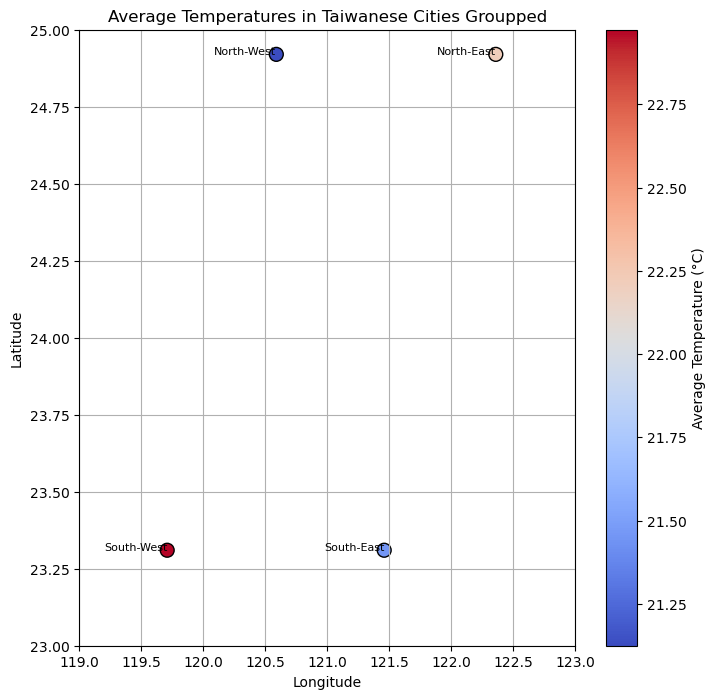

In [215]:
data = {
    'CityGroup': ['North-East', 'South-East', 'North-West', 'South-West'],
    'AverageTemperature': [22.212440, 21.449923, 21.124517, 22.973854],
    'Latitude': [24.92, 23.31, 24.92, 23.31],
    'Longitude': [122.36, 121.46, 120.59, 119.71]
}

df_groupcities = pd.DataFrame(data)

# Create a Geopandas GeoDataFrame for plotting
gdf_cities = gpd.GeoDataFrame(df_groupcities, 
                              geometry=gpd.points_from_xy(df_groupcities['Longitude'], df_groupcities['Latitude']))

# Plot the cities with colors based on average temperatures
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of cities, with color representing temperature
scatter = ax.scatter(df_groupcities['Longitude'], df_groupcities['Latitude'], 
                     c=df_groupcities['AverageTemperature'], cmap='coolwarm', s=100, edgecolor='black')

# Annotate each city
for i, row in df_groupcities.iterrows():
    ax.text(row['Longitude'], row['Latitude'], row['CityGroup'], fontsize=8, ha='right')

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average Temperature (°C)')

# Set axis limits to focus on Taiwan
ax.set_xlim(119, 123)
ax.set_ylim(23, 25)
ax.set_title('Average Temperatures in Taiwanese Cities Groupped')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## 4. Trendline plot
Plot the trendline for average temperature for all records in the dataset with unceratinty intervals, alongside an arbitrarily set threshold for the start of global warming (in this case 1970).

In [216]:
# Extract the year from the date
df_tw_groups['Year'] = df_tw_groups['dt'].apply(lambda x: x[:4])

# Group by year and calculate the average temperature and uncertainty
tw_yearly = df_tw_groups.groupby('Year').agg({
    'AverageTemperature': 'mean',
    'AverageTemperatureUncertainty': 'mean'
}).reset_index()

# Extract the values
years = tw_yearly['Year'].astype(int).values
mean_temp_tw = tw_yearly['AverageTemperature'].values
mean_temp_tw_uncertainty = tw_yearly['AverageTemperatureUncertainty'].values

# Calculate the trend line (linear regression)
slope, intercept, r_value, p_value, std_err = stats.linregress(years, mean_temp_tw)
trend_line = slope * years + intercept

# Create traces for the plot
trace0 = go.Scatter(
    x=years, 
    y=mean_temp_tw + mean_temp_tw_uncertainty,
    fill=None,
    mode='lines',
    name='Uncertainty top',
    line=dict(color='rgb(0, 255, 255)')
)

trace1 = go.Scatter(
    x=years, 
    y=mean_temp_tw - mean_temp_tw_uncertainty,
    fill='tonexty',
    mode='lines',
    name='Uncertainty bot',
    line=dict(color='rgb(0, 255, 255)')
)

trace2 = go.Scatter(
    x=years, 
    y=mean_temp_tw,
    name='Average Temperature',
    line=dict(color='rgb(199, 121, 093)')
)

# Add the trend line
trace3 = go.Scatter(
    x=years,
    y=trend_line,
    name='Trend Line',
    line=dict(color='rgb(255, 0, 0)', dash='dash')
)

# Add a vertical line to indicate the start of global warming (around 1970)
global_warming_start_year = 1970

trace4 = go.Scatter(
    x=[global_warming_start_year, global_warming_start_year],
    y=[min(mean_temp_tw - mean_temp_tw_uncertainty), max(mean_temp_tw + mean_temp_tw_uncertainty)],
    mode='lines',
    name='Start of Global Warming',
    line=dict(color='rgb(0, 100, 0)', dash='dot')
)

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average Land Temperature in Taiwan with Trend Line and Global Warming Start',
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)
fig.show()

## 5. Seasonal analysis
Here we start a seasonal analysis of AverageTemperature records, this will enable us to engineer some new features to later feed the Machine Learning models

### 5.1. Monthly temperature patterns
From this plot we can determine that the dataset has the same temperature records for four groups of cities within Taiwan, as it can be seen only 4 trend lines appear, when we were expecting 30 different ones.

## 

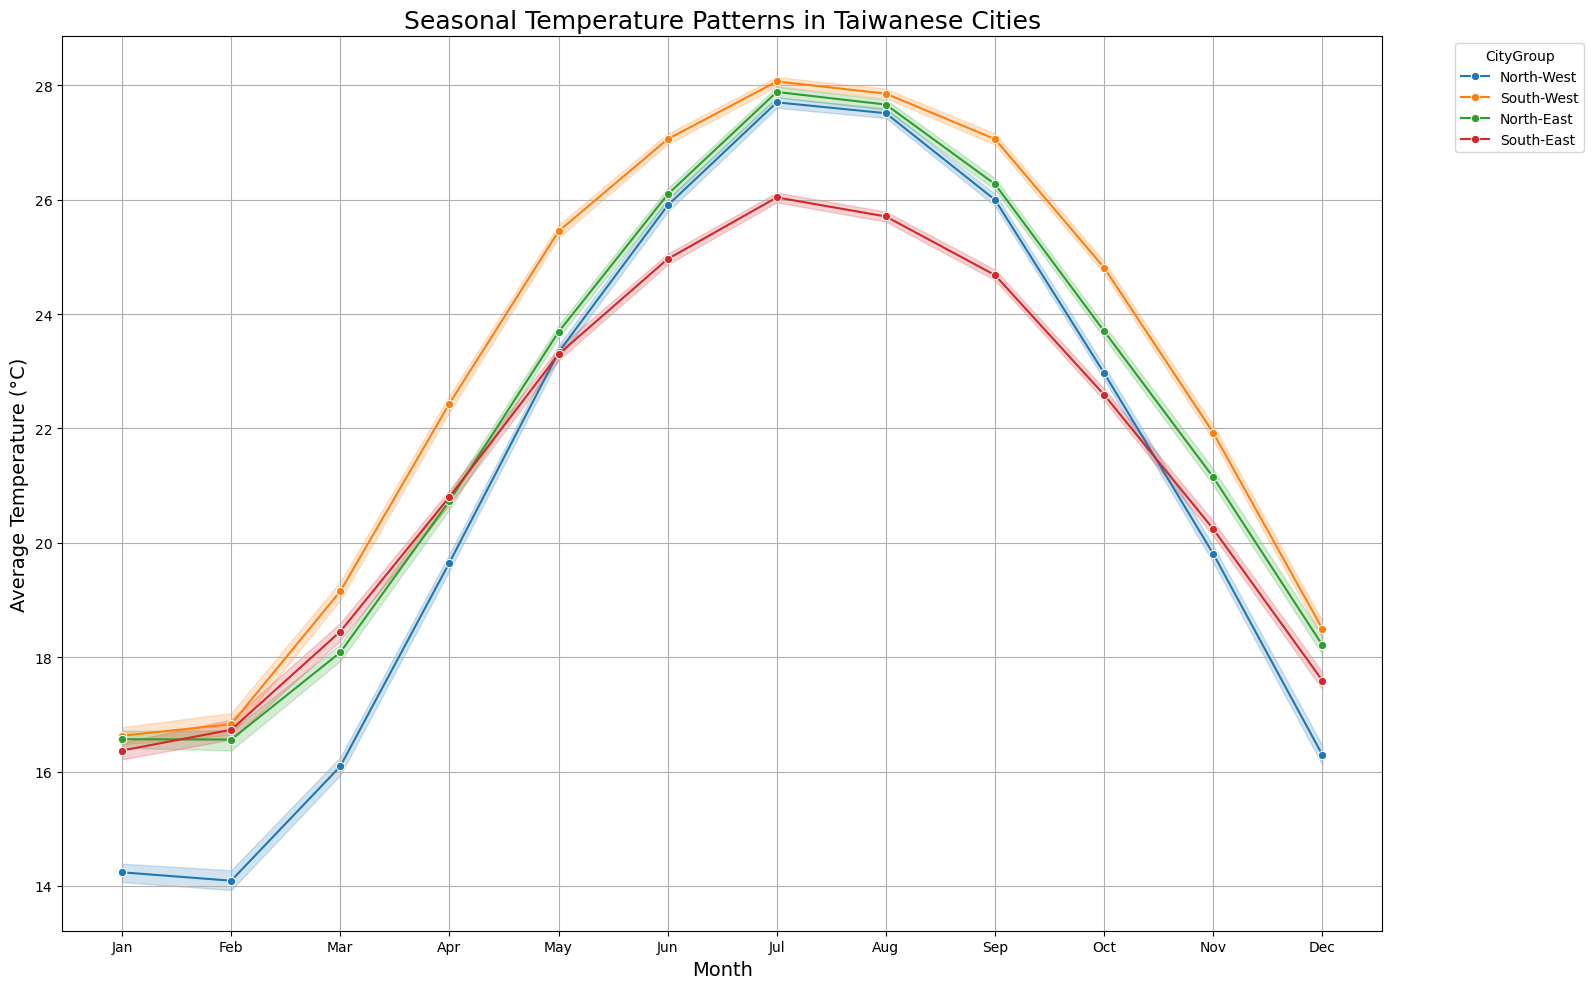

In [217]:
# Convert 'dt' to datetime format
df_tw_groups['dt'] = pd.to_datetime(df_tw['dt'])

# Grouping data by seasons
df_tw_groups['Month'] = df_tw_groups['dt'].dt.month

# Plot
plt.figure(figsize=(16, 10))
sns.lineplot(data=df_tw_groups, x='Month', y='AverageTemperature', hue='CityGroup', marker='o')
plt.title('Seasonal Temperature Patterns in Taiwanese Cities', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='CityGroup', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.2. Average temperature variation in Taiwan per season

/tmp/ipykernel_1281/371221358.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




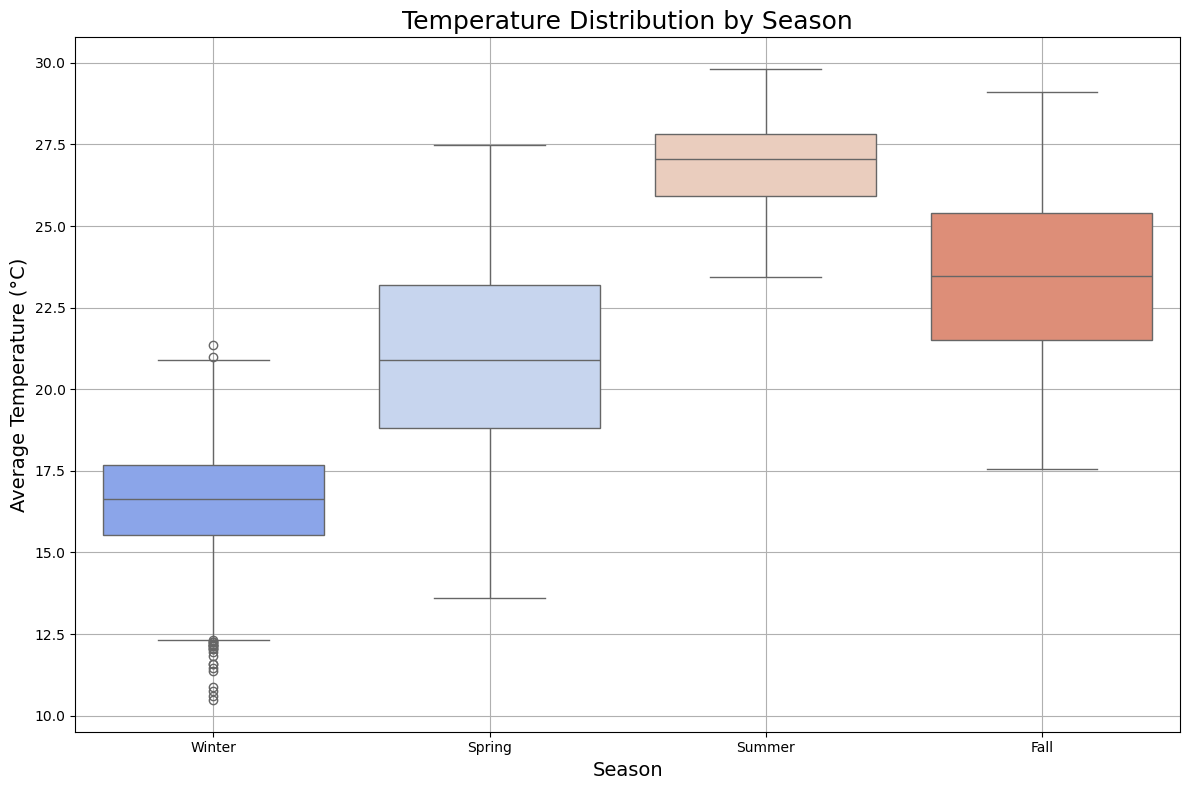

In [218]:
# Rename the dt dataframe column
df_tw_groups = df_tw_groups.rename(columns={'dt': 'date'})

# Create new dataframe with date time features and seasons
df_features = df_tw_groups.copy()
df_features['date'] = pd.to_datetime(df_features['date'])
df_features['Year'] = df_features['date'].dt.year
df_features['Month'] = df_features['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    
df_features['season'] = df_features['date'].dt.month.apply(get_season)

# Box Plot for temperatures distribution in Taiwan per season
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_features, x='season', y='AverageTemperature', palette='coolwarm')
plt.title('Temperature Distribution by Season', fontsize=18)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.2. Average temperature in Taiwan per season

/tmp/ipykernel_1281/4216527761.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_1281/4216527761.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




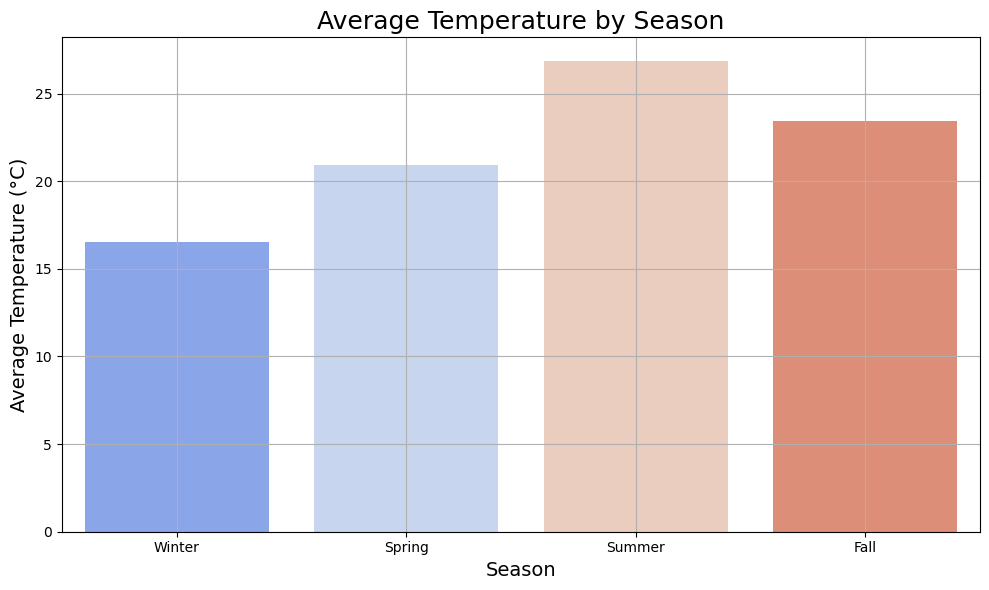

In [219]:
# Ensure 'season' column is categorical with specific order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
df_features['season'] = pd.Categorical(df_features['season'], categories=season_order, ordered=True)

# Compute the average temperature by season
seasonal_avg_temp = df_features.groupby('season')['AverageTemperature'].mean().reset_index()

# Bar plot for average temperature by season
plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_avg_temp, x='season', y='AverageTemperature', palette='coolwarm')
plt.title('Average Temperature by Season', fontsize=18)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.3. Average temperature anomalies per season

/tmp/ipykernel_1281/593458310.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_1281/593458310.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_1281/593458310.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




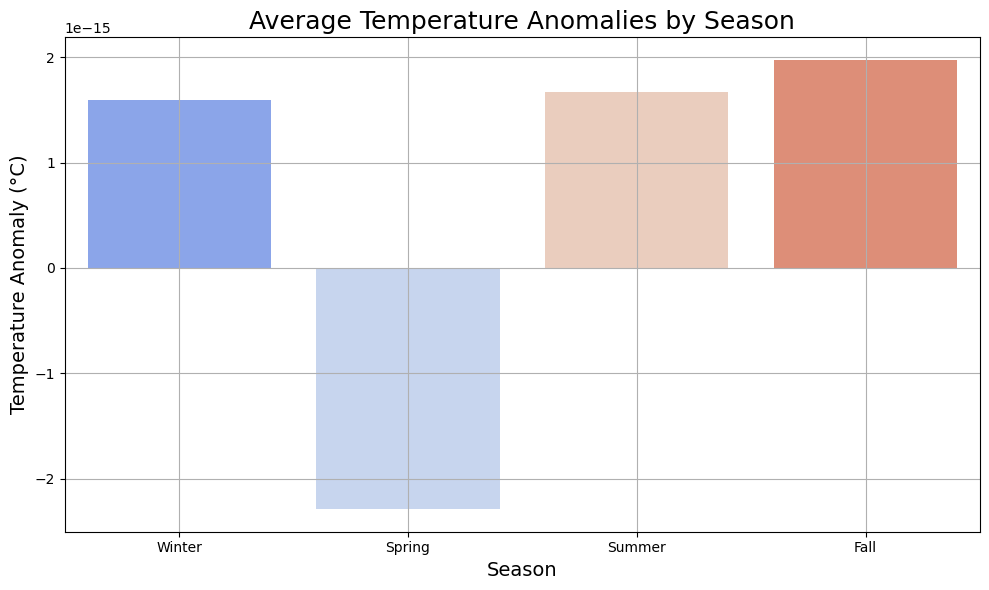

In [220]:
# Create one extra column in the dataframe to indicate weather the temperature is above or
# below the average of that season.
baseline_avg_temp = df_features.groupby('season')['AverageTemperature'].mean()
df_features['Anomaly'] = df_features.apply(lambda row: row['AverageTemperature'] - baseline_avg_temp[row['season']], axis=1)

# Compute average anomalies by season
seasonal_anomalies = df_features.groupby('season')['Anomaly'].mean().reset_index()

# Plot anomalies
plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_anomalies, x='season', y='Anomaly', palette='coolwarm')
plt.title('Average Temperature Anomalies by Season', fontsize=18)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Temperature Anomaly (°C)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.4. Seasonal temperature trends over time

/tmp/ipykernel_1281/438078679.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



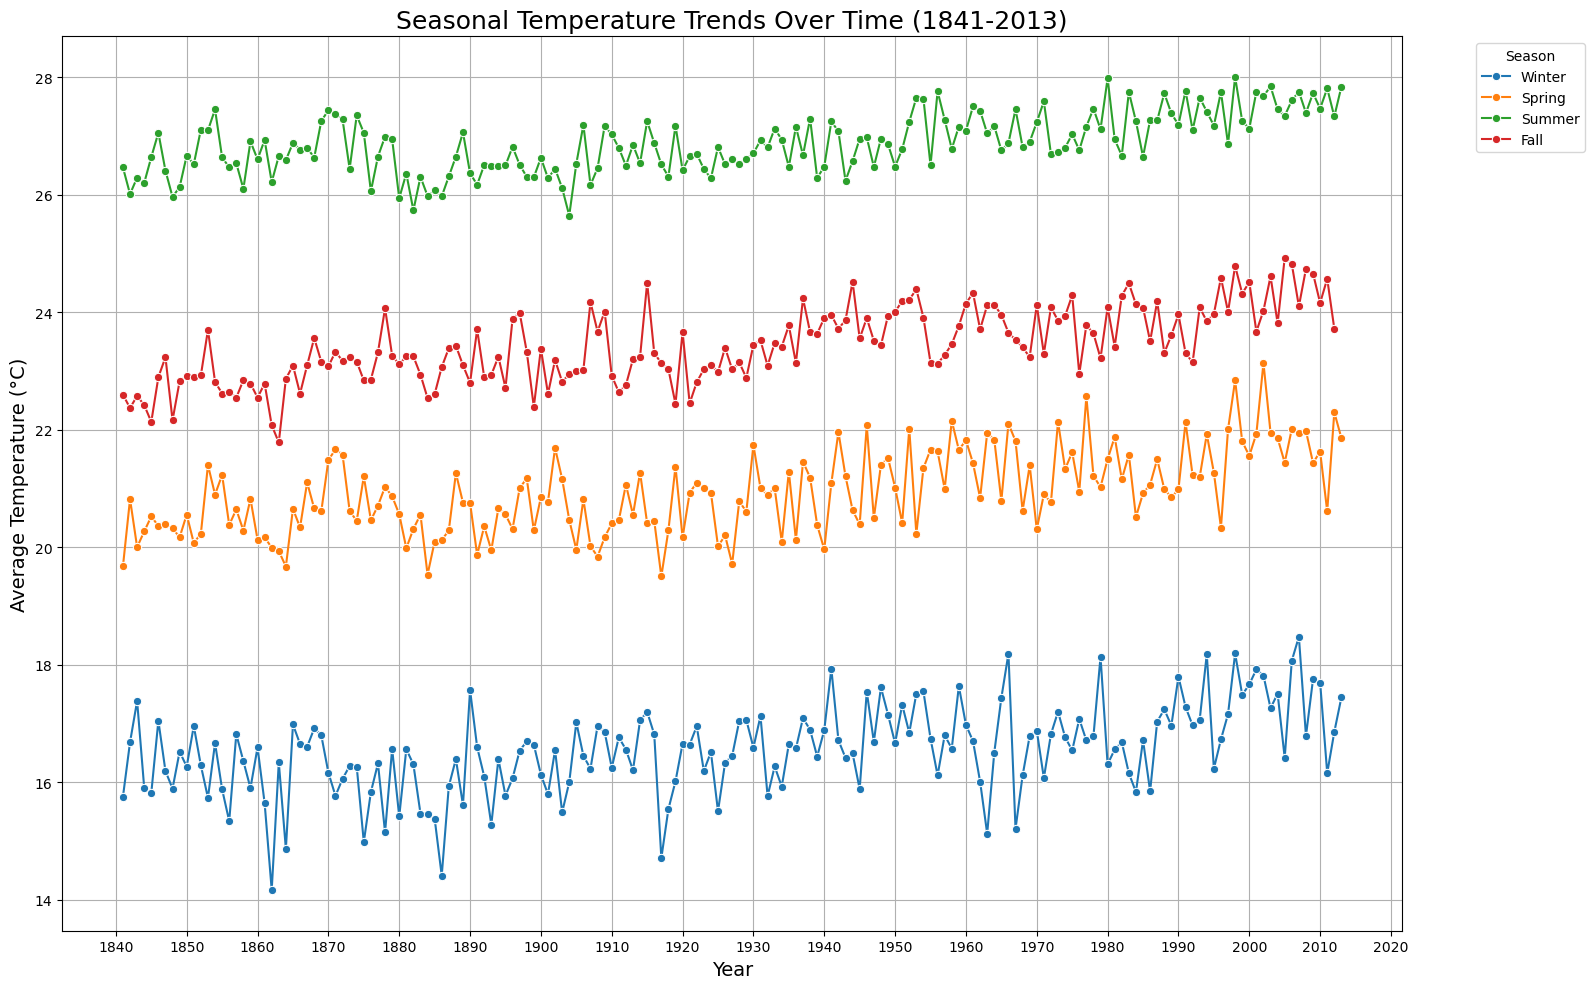

In [221]:
# Compute average temperature for each season and year
seasonal_temp_trend = df_features.groupby(['Year', 'season'])['AverageTemperature'].mean().reset_index()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
sns.lineplot(data=seasonal_temp_trend, x='Year', y='AverageTemperature', hue='season', marker='o')
ax.set_title('Seasonal Temperature Trends Over Time (1841-2013)', fontsize=18)
ax.set_xlabel('Year', fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(20))
ax.set_ylabel('Average Temperature (°C)', fontsize=14)
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Plot missing values heatmap

Plot of the null values in the dataframe.

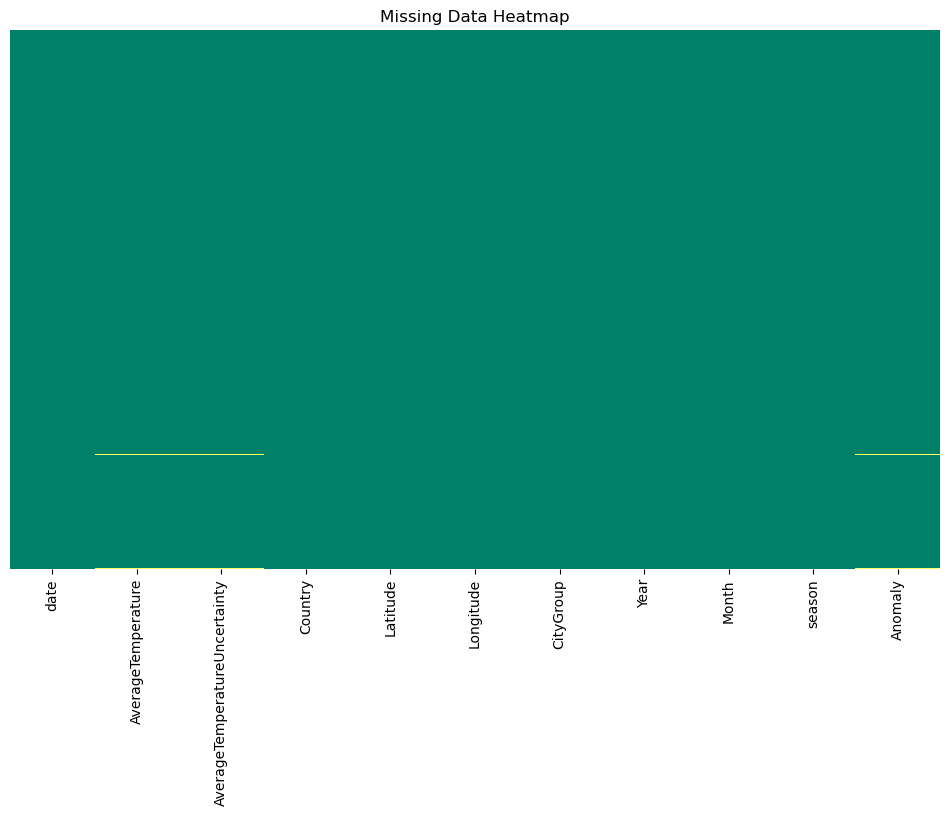

In [222]:
# Plot missing values heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(df_features.isnull(), cbar=False, cmap='summer', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

## 7. Climate Types Feature
We use spatial inference from the coordinate maps from Koppen-Geiger maps focalized on the Taiwan area, which classifies different areas of Taiwan according to their climate type.

<img src="img/Koppen-Geiger_Map_TWN_present.png" width="600" align="center">

Beck, H.E., Zimmermann, N. E., McVicar, T. R., Vergopolan, N., Berg, A., & Wood, E. F.: *Present and future Köppen-Geiger climate classification maps at 1-km resolution* Nature Scientific Data. DOI:[10.1038/sdata.2018.214](https://doi.org/10.1038/sdata.2018.214)

### 7.1. Dictionary with Taiwan coordinates and the climate type assigned to each coordinate

In [223]:
# Define Taiwan's bounding box
taiwan_bbox = {
    "type": "Polygon",
    "coordinates": [[
        [119.5, 20.5],
        [122.5, 20.5],
        [122.5, 25.5],
        [119.5, 25.5],
        [119.5, 20.5]
    ]]
}

# Open the Köppen-Geiger map
tiff_path = "koppen-geiger-maps/koppen_geiger_0p1.tif"
with rasterio.open(tiff_path) as dataset:
    # Crop to Taiwan's bounding box
    taiwan_geom = [box(119.5, 20.5, 122.5, 25.5)]
    taiwan_data, taiwan_transform = mask(dataset, taiwan_geom, crop=True)
    
    # Get metadata
    cropped_meta = dataset.meta.copy()
    cropped_meta.update({
        "height": taiwan_data.shape[1],
        "width": taiwan_data.shape[2],
        "transform": taiwan_transform
    })

# Extract pixel data and coordinates
climate_data = []
with rasterio.open(tiff_path) as dataset:
    for row in range(taiwan_data.shape[1]):
        for col in range(taiwan_data.shape[2]):
            value = taiwan_data[0, row, col]  # Band 1
            if value != dataset.nodata:  # Skip no-data values
                # Map pixel (row, col) to (lon, lat)
                lon, lat = rasterio.transform.xy(taiwan_transform, row, col, offset="center")
                climate_data.append({"latitude": lat, "longitude": lon, "classification": value})

print(climate_data)

[{'latitude': 25.45, 'longitude': 119.55, 'classification': 14}, {'latitude': 25.45, 'longitude': 119.65, 'classification': 14}, {'latitude': 25.45, 'longitude': 119.75, 'classification': 14}, {'latitude': 25.45, 'longitude': 119.85, 'classification': 14}, {'latitude': 25.45, 'longitude': 119.95, 'classification': 14}, {'latitude': 25.45, 'longitude': 122.15, 'classification': 14}, {'latitude': 25.35, 'longitude': 119.55, 'classification': 14}, {'latitude': 25.35, 'longitude': 119.65, 'classification': 14}, {'latitude': 25.35, 'longitude': 119.75, 'classification': 14}, {'latitude': 25.25, 'longitude': 119.55, 'classification': 14}, {'latitude': 25.25, 'longitude': 119.75, 'classification': 14}, {'latitude': 25.25, 'longitude': 121.45, 'classification': 14}, {'latitude': 25.25, 'longitude': 121.55, 'classification': 14}, {'latitude': 25.25, 'longitude': 121.65, 'classification': 14}, {'latitude': 25.15, 'longitude': 119.55, 'classification': 14}, {'latitude': 25.15, 'longitude': 121.25

### 7.2. Dataframe of all climate types

In [224]:
# Map classification values to climate types
koppen_classes = {
    1: ('Af', 'Tropical, rainforest', [0, 0, 255]), 
    2: ('Am', 'Tropical, monsoon', [0, 120, 255]), 
    3: ('Aw', 'Tropical, savannah', [70, 170, 250]), 
    4: ('BWh', 'Arid, desert, hot', [255, 0, 0]), 
    5: ('BWk', 'Arid, desert, cold', [255, 150, 150]), 
    6: ('BSh', 'Arid, steppe, hot', [245, 165, 0]), 
    7: ('BSk', 'Arid, steppe, cold', [255, 220, 100]), 
    8: ('Csa', 'Temperate, dry summer, hot summer', [255, 255, 0]), 
    9: ('Csb', 'Temperate, dry summer, warm summer', [200, 200, 0]), 
    10: ('Csc', 'Temperate, dry summer, cold summer', [150, 150, 0]), 
    11: ('Cwa', 'Temperate, dry winter, hot summer', [150, 255, 150]), 
    12: ('Cwb', 'Temperate, dry winter, warm summer', [100, 200, 100]), 
    13: ('Cwc', 'Temperate, dry winter, cold summer', [50, 150, 50]), 
    14: ('Cfa', 'Temperate, no dry season, hot summer', [200, 255, 80]), 
    15: ('Cfb', 'Temperate, no dry season, warm summer', [100, 255, 80]), 
    16: ('Cfc', 'Temperate, no dry season, cold summer', [50, 200, 0]), 
    17: ('Dsa', 'Cold, dry summer, hot summer', [255, 0, 255]), 
    18: ('Dsb', 'Cold, dry summer, warm summer', [200, 0, 200]), 
    19: ('Dsc', 'Cold, dry summer, cold summer', [150, 50, 150]), 
    20: ('Dsd', 'Cold, dry summer, very cold winter', [150, 100, 150]), 
    21: ('Dwa', 'Cold, dry winter, hot summer', [170, 175, 255]), 
    22: ('Dwb', 'Cold, dry winter, warm summer', [90, 120, 220]), 
    23: ('Dwc', 'Cold, dry winter, cold summer', [75, 80, 180]), 
    24: ('Dwd', 'Cold, dry winter, very cold winter', [50, 0, 135]), 
    25: ('Dfa', 'Cold, no dry season, hot summer', [0, 255, 255]), 
    26: ('Dfb', 'Cold, no dry season, warm summer', [55, 200, 255]), 
    27: ('Dfc', 'Cold, no dry season, cold summer', [0, 125, 125]), 
    28: ('Dfd', 'Cold, no dry season, very cold winter', [0, 70, 95]), 
    29: ('ET', 'Polar, tundra', [178, 178, 178]), 
    30: ('EF', 'Polar, frost', [102, 102, 102])
}

koppen_df = pd.DataFrame.from_dict(
    koppen_classes, 
    orient='index', 
    columns=['code', 'description', 'RGBcolor']
)
koppen_df.reset_index(inplace=True)
koppen_df.rename(columns={'index': 'classification'}, inplace=True)

print(koppen_df.head(5))

   classification code           description         RGBcolor
0               1   Af  Tropical, rainforest      [0, 0, 255]
1               2   Am     Tropical, monsoon    [0, 120, 255]
2               3   Aw    Tropical, savannah   [70, 170, 250]
3               4  BWh     Arid, desert, hot      [255, 0, 0]
4               5  BWk    Arid, desert, cold  [255, 150, 150]


In [225]:
# Convert koppen_df to a lookup dictionary
koppen_dict = koppen_df.set_index("classification").to_dict("index")

# Loop through each entry and enrich with climate type information
for entry in climate_data:    
    classification = entry["classification"]
    koppen_info = koppen_dict.get(classification, ("Unknown", "Unknown", [0, 0, 0]))
    entry["climate_code"] = koppen_info["code"]
    entry["description"] = koppen_info["description"]
    entry["color"] = koppen_info["RGBcolor"]

print(climate_data[:2])

[{'latitude': 25.45, 'longitude': 119.55, 'classification': 14, 'climate_code': 'Cfa', 'description': 'Temperate, no dry season, hot summer', 'color': [200, 255, 80]}, {'latitude': 25.45, 'longitude': 119.65, 'classification': 14, 'climate_code': 'Cfa', 'description': 'Temperate, no dry season, hot summer', 'color': [200, 255, 80]}]


In [226]:
# Save to CSV
df_map = pd.DataFrame(climate_data)
df_map.to_csv("taiwan_climate_data.csv", index=False)

print(df_map.head(2))

   latitude  longitude  classification climate_code  \
0     25.45     119.55              14          Cfa   
1     25.45     119.65              14          Cfa   

                            description           color  
0  Temperate, no dry season, hot summer  [200, 255, 80]  
1  Temperate, no dry season, hot summer  [200, 255, 80]  


### 7.3. Computing distance from cities coordinates to the closest coordinate in climate types map

In [227]:
# Define the haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

In [228]:
# Calculate the distance between each citygroup and each climate point
distances = []
for index, city in df_aux.iterrows():
    city_distances = []
    for index, climate in df_map.iterrows():
        lat_df = float(city['Latitude'][:-1])
        long_df = float(city['Longitude'][:-1])
        distance = haversine(lat_df, long_df, climate['latitude'], climate['longitude'])
        city_distances.append(distance)
    distances.append(city_distances)

# Find the closest climate point for each city
closest_climates = []
for city_distances in distances:
    closest_index = np.argmin(city_distances)
    closest_climate = df_map.iloc[closest_index]['climate_code']
    closest_climates.append(closest_climate)

# Add the closest climate
df_aux['climate_type'] = closest_climates

# Create a dictionary mapping CityGroup to climate_type
city_group_map = df_aux.set_index('CityGroup')['climate_type'].to_dict()

# Use the map function to copy the climate_type feature to the second dataframe
df_features['climate_type'] = df_features['CityGroup'].map(city_group_map)

print(df_features['climate_type'].value_counts())

climate_type
Cfa    6219
Aw     2073
Name: count, dtype: int64


## 8. Handling missing values (NULLS)
In this section I will explore three methods to handle NULL values by statistical imputation (by mean, median and most frequent value).

### 8.1. How many missing records we have

In [229]:
print(df_features.isnull().sum())

date                              0
AverageTemperature               11
AverageTemperatureUncertainty    11
Country                           0
Latitude                          0
Longitude                         0
CityGroup                         0
Year                              0
Month                             0
season                            0
Anomaly                          11
climate_type                      0
dtype: int64


### 8.2. Statistical Imputation
[link](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [230]:
def statistical_impute(df, method):
    numeric_data = df.select_dtypes(include=['number'])
    categorical_data = df.select_dtypes(exclude=['number'])
    
    if method in ['mean', 'median']:
        imputer_numeric = SimpleImputer(strategy=method)
        df[numeric_data.columns] = imputer_numeric.fit_transform(numeric_data)
    elif method == 'most_frequent':
        imputer_non_numeric = SimpleImputer(strategy='most_frequent')
        df[categorical_data.columns] = imputer_non_numeric.fit_transform(categorical_data)
    else:
        raise ValueError("Method should be 'mean', 'median' for numeric columns or 'most_frequent' for categorical columns.")
    
    return df

df_statistical_impute_mean = statistical_impute(df_features,'mean')
df_statistical_impute_median = statistical_impute(df_features,'median')
df_statistical_impute_most_frequent = statistical_impute(df_features,'most_frequent')

print('Imputing NULLS by mean')
print(df_statistical_impute_mean.isnull().sum())
print('Imputing NULLS by median')
print(df_statistical_impute_median.isnull().sum())
print('Imputing NULLS by most frequent value')
print(df_statistical_impute_most_frequent.isnull().sum())

Imputing NULLS by mean
date                             0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
Latitude                         0
Longitude                        0
CityGroup                        0
Year                             0
Month                            0
season                           0
Anomaly                          0
climate_type                     0
dtype: int64
Imputing NULLS by median
date                             0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
Latitude                         0
Longitude                        0
CityGroup                        0
Year                             0
Month                            0
season                           0
Anomaly                          0
climate_type                     0
dtype: int64
Imputing NULLS by most frequent value
date                             0
AverageTemper

## 9. Dropping Columns
Dropping columns and separating numerical and categorical data.

In [231]:
df_tw_clean = df_statistical_impute_median.drop(columns=['Country', 'Longitude', 'Latitude'])
print(df_tw_clean.head(2))

        date  AverageTemperature  AverageTemperatureUncertainty   CityGroup  \
0 1841-01-01              13.108                          2.519  North-West   
1 1841-02-01              13.234                          1.908  North-West   

     Year  Month  season   Anomaly climate_type  
0  1841.0    1.0  Winter -3.439183          Cfa  
1  1841.0    2.0  Winter -3.313183          Cfa  


In [232]:
numeric_data = df_statistical_impute_median.select_dtypes(include=['number'])
categorical_data = df_statistical_impute_median.select_dtypes(exclude=['number'])
print(numeric_data.head(2))
print(categorical_data.head(2))

   AverageTemperature  AverageTemperatureUncertainty    Year  Month   Anomaly
0              13.108                          2.519  1841.0    1.0 -3.439183
1              13.234                          1.908  1841.0    2.0 -3.313183
        date Country Latitude Longitude   CityGroup  season climate_type
0 1841-01-01  Taiwan   24.92N   120.59E  North-West  Winter          Cfa
1 1841-02-01  Taiwan   24.92N   120.59E  North-West  Winter          Cfa


## 10. Outlier handling
We want to identify data points that are significantly different from the rest of the data.

### 10.1. Outlier detection

In [233]:
def count_outliers(column):
    if pd.api.types.is_numeric_dtype(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = column[(column < lower_bound) | (column > upper_bound)]
        return len(outliers)
    else:
        return 0 
    
for index, col in enumerate(numeric_data.columns):
    column_data = numeric_data[col]
    outliers = count_outliers(column_data)
    print(col,  outliers)

AverageTemperature 0
AverageTemperatureUncertainty 157
Year 0
Month 0
Anomaly 67


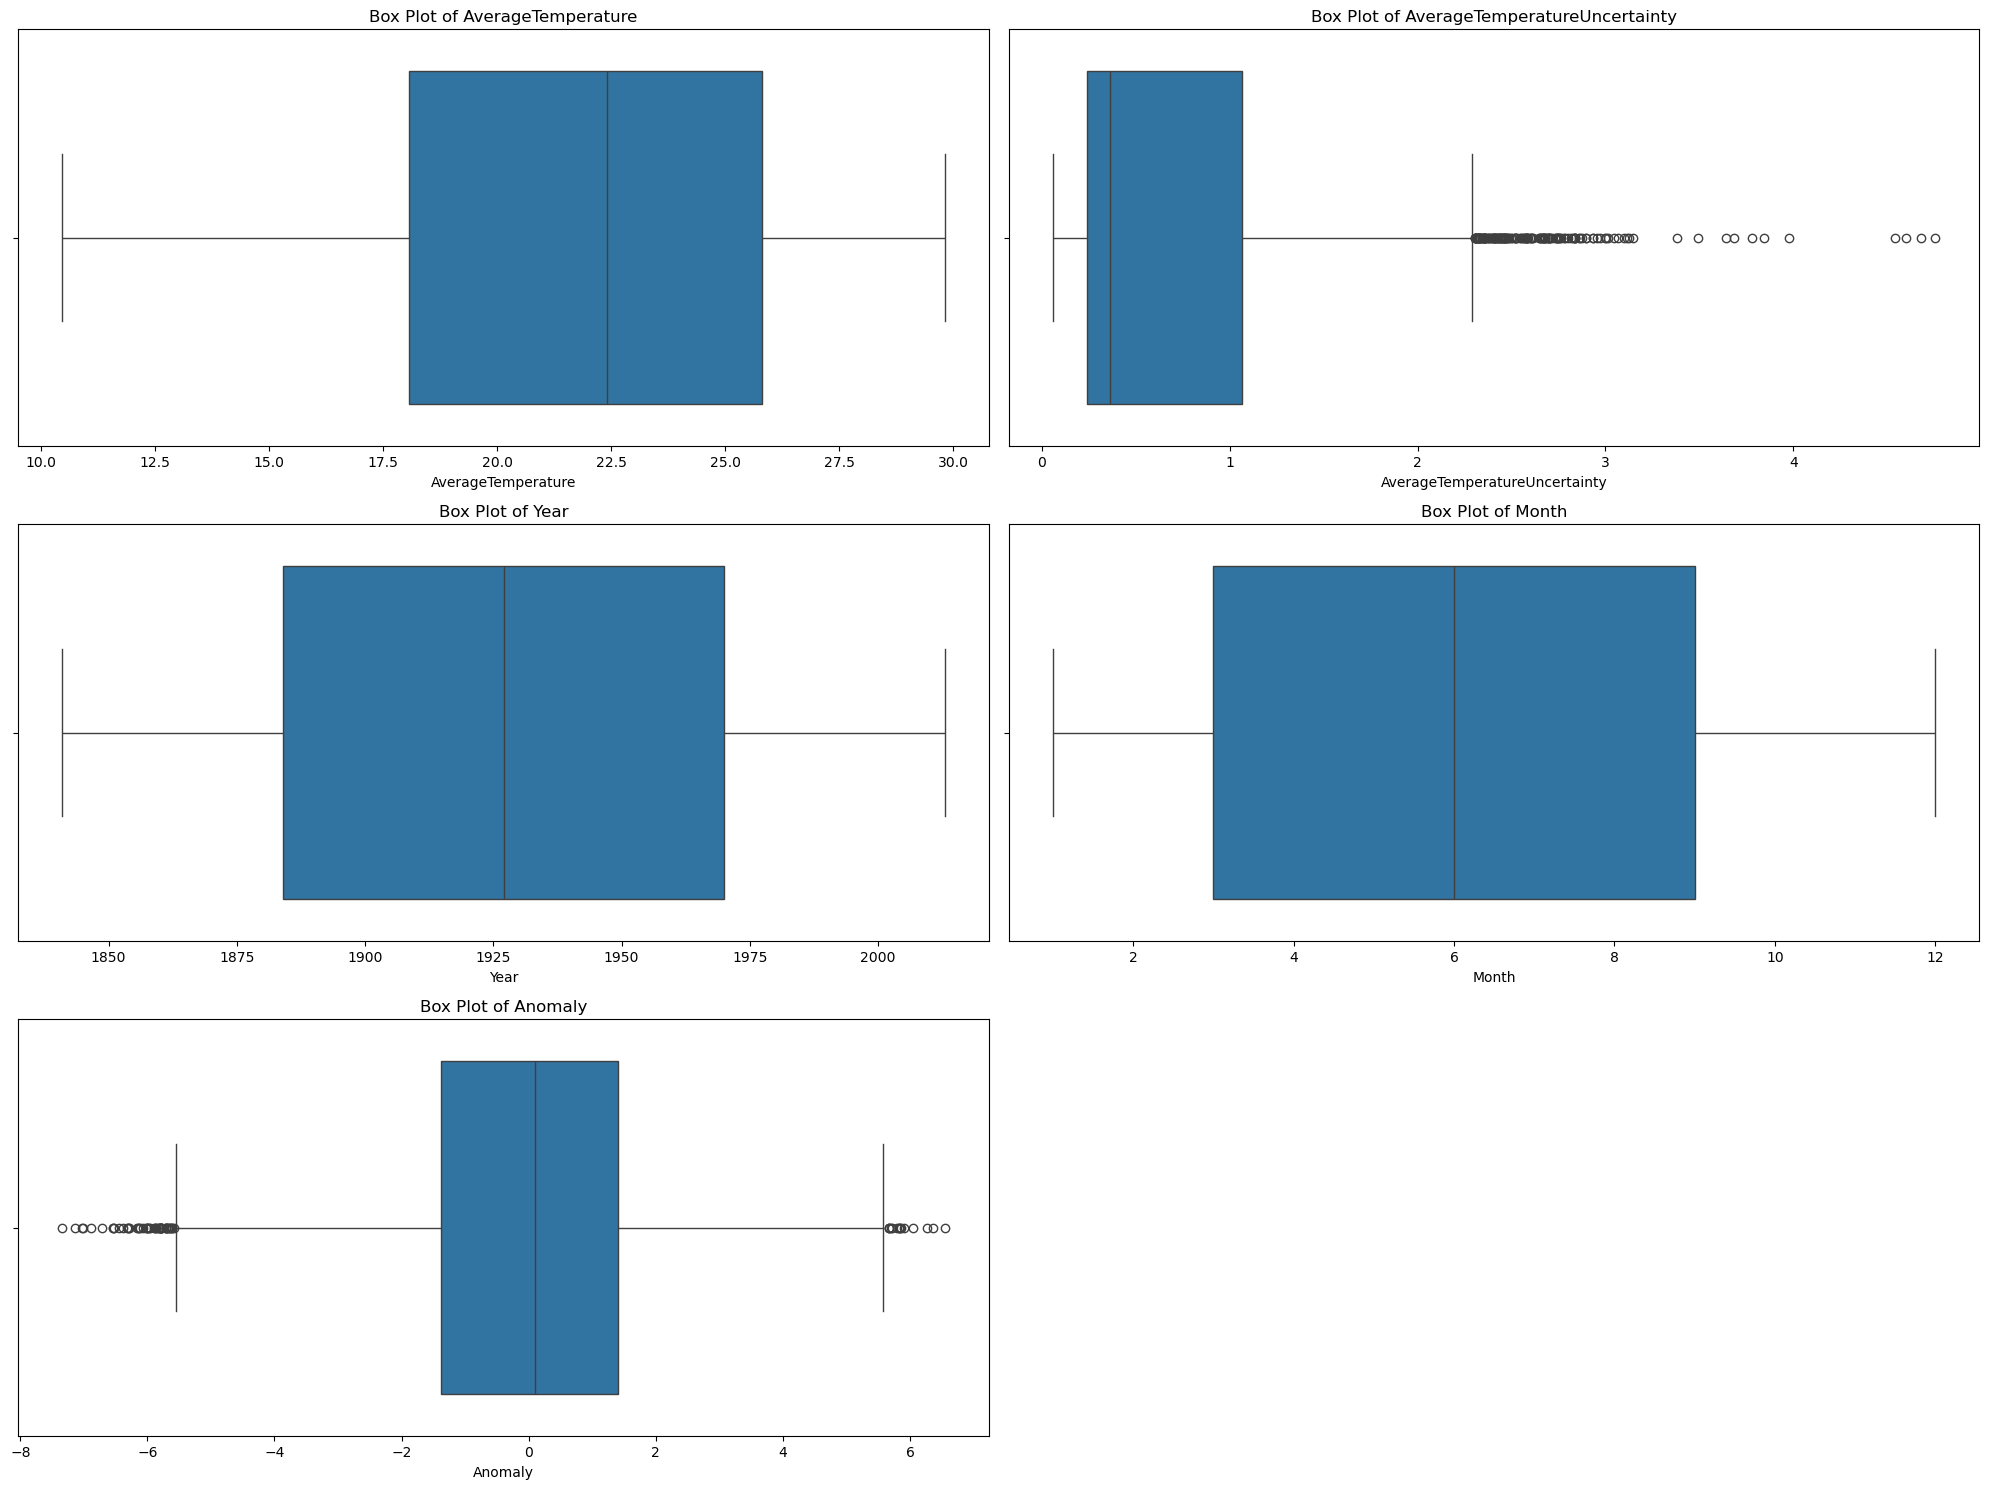

In [234]:
plt.figure(figsize=(20, 15))
for n, feature in enumerate(numeric_data.columns):
    plt.subplot(3, 2, n + 1)
    sns.boxplot(data=df_features, x=feature)
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

### 10.2. Mean/Median imputation
I study two different approaches to the handling of outliers in the data, these are:
- **Mean imputation**: Replacing outliers with the mean of the feature.
- **Median imputation**: Replacing outliers with the median of the feature.

In [235]:
def impute_outliers_with_mean_median(df, numeric_columns, method):
    for col in numeric_columns:
        outlier_count = count_outliers(df[col])  
        
        if outlier_count > 0:
            if method == 'mean':
                impute_value = df[col].mean()
            elif method == 'median':
                impute_value = df[col].median()
            else:
                raise ValueError("Method should be either 'mean' or 'median'")

            # Replace outliers with the imputation value
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = impute_value
    return df

df_impute_outliers_with_mean = impute_outliers_with_mean_median(df_statistical_impute_median, numeric_data.columns, 'mean')

for index, col in enumerate(df_impute_outliers_with_mean.columns):
    column_data = df_impute_outliers_with_mean[col]
    outliers = count_outliers(column_data)
    print(col,  outliers)

date 0
AverageTemperature 0
AverageTemperatureUncertainty 97
Country 0
Latitude 0
Longitude 0
CityGroup 0
Year 0
Month 0
season 0
Anomaly 19
climate_type 0


In [236]:
df_impute_outliers_with_median = impute_outliers_with_mean_median(df_statistical_impute_median, numeric_data.columns, 'median')

for index, col in enumerate(df_impute_outliers_with_median.columns):
    column_data = df_impute_outliers_with_median[col]
    outlier_count = count_outliers(column_data)
    print(col, outlier_count)

date 0
AverageTemperature 0
AverageTemperatureUncertainty 111
Country 0
Latitude 0
Longitude 0
CityGroup 0
Year 0
Month 0
season 0
Anomaly 3
climate_type 0


## 11. Data Transformation
Data transformation can improve the model's performance by reducing noise and improving the model's ability to capture patterns and trends. We will check three main procedures: data upsampling, checking stationarity of target samples and tail rolling.

### 11.1. Upsampling
Upsampling helps by increasing data density, that can improve the model's ability to capture patterns and trends in the data. It can help reduce noise in the data by averaging out random fluctuations. The strategy followed is:
- Upsample the data to a daily frequency (instead of monthly).
- Interpolate missing values in the upsampled dataframe using [spline interpolation](https://en.wikipedia.org/wiki/Spline_interpolation) of order 2.
- Combine both the above and clean the dataframe.

In [237]:
# Convert 'date' column to datetime format and set it as the index of the dataframe
df_impute_outliers_with_median['date'] = pd.to_datetime(df_impute_outliers_with_median['date'], errors='coerce')
df_impute_outliers_with_median.set_index('date', inplace=True)
print(df_impute_outliers_with_median)

            AverageTemperature  AverageTemperatureUncertainty Country  \
date                                                                    
1841-01-01           13.108000                       0.677271  Taiwan   
1841-02-01           13.234000                       1.908000  Taiwan   
1841-03-01           14.386000                       0.677271  Taiwan   
1841-04-01           18.287000                       2.057000  Taiwan   
1841-05-01           22.627000                       1.423000  Taiwan   
...                        ...                            ...     ...   
2013-05-01           24.013000                       0.322000  Taiwan   
2013-06-01           26.182000                       0.410000  Taiwan   
2013-07-01           26.700000                       0.515000  Taiwan   
2013-08-01           26.710000                       0.428000  Taiwan   
2013-09-01           21.940216                       0.677271  Taiwan   

           Latitude Longitude   CityGroup    Year 

### 11.3. Checking for stationarity
We will perform the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) on AverageTemperature feature.

In [238]:
result = adfuller(df_impute_outliers_with_median['AverageTemperature'])
print('ADF test')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF test
ADF Statistic: -3.702977
p-value: 0.004071
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The results of the Augmented Dickey-Fuller (ADF) test indicate that the null hypothesis of non-stationarity can be rejected in favor of the alternative hypothesis of stationarity. Here is a breakdown of the results:
- **ADF statistic: -3.702977**. This is the test statistic, which is a measure of how far the data is from being non-stationary. A more negative value indicates stronger evidence against the null hypothesis of non-stationarity.
- **p-value: 0.004071**. This is the probability of observing a test statistic at least as extreme as the one observed, assuming that the null hypothesis is true. In this case, the p-value is extremely small, indicating that the observed test statistic is highly unlikely to occur by chance if the null hypothesis is true.
- **Critical values**. These are the threshold values for the test statistic at different significance levels (1%, 5%, and 10%). If the test statistic is more negative than the critical value, the null hypothesis can be rejected at that significance level.

In this case, the test statistic (-3.702977) is more negative than all of the critical values (-3.431, -2.862, and -2.567), indicating that the null hypothesis of non-stationarity can be rejected at all three significance levels.

## 12. Add Lag features

In [239]:
df_export = df_impute_outliers_with_median.copy()
df_export['AverageTemperatureChangeVsLastMonth'] = df_export['AverageTemperature'] - df_export['AverageTemperature'].shift(1)
df_export = statistical_impute(df_export, 'median')
print(df_export)
print(df_export["CityGroup"].value_counts())

            AverageTemperature  AverageTemperatureUncertainty Country  \
date                                                                    
1841-01-01           13.108000                       0.677271  Taiwan   
1841-02-01           13.234000                       1.908000  Taiwan   
1841-03-01           14.386000                       0.677271  Taiwan   
1841-04-01           18.287000                       2.057000  Taiwan   
1841-05-01           22.627000                       1.423000  Taiwan   
...                        ...                            ...     ...   
2013-05-01           24.013000                       0.322000  Taiwan   
2013-06-01           26.182000                       0.410000  Taiwan   
2013-07-01           26.700000                       0.515000  Taiwan   
2013-08-01           26.710000                       0.428000  Taiwan   
2013-09-01           21.940216                       0.677271  Taiwan   

           Latitude Longitude   CityGroup    Year 

## 13. Encoding
We encode using one-hot encoding the categorical data and using cyclic encoding for the month feature (it represents the months as function of sine and cosine to enhance the cyclic nature of the feature).

In [240]:
from sklearn.preprocessing import StandardScaler

def encoding(df):    
    # One-Hot Encoding for specific categorical features
    one_hot_encoded_columns = ['CityGroup', 'season', 'climate_type']
    encoder = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
    encoded_cols = encoder.fit_transform(df[one_hot_encoded_columns])
    df.drop(columns=one_hot_encoded_columns,inplace=True)
    df[encoder.get_feature_names_out()]=encoded_cols

    # Cyclic Encoding for month feature
    df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)
    df = df.drop(columns=['Month'])

    # Sinusoidal encoding for latitude and longitude
    df['Latitude'] = df['Latitude'].apply(lambda x: np.radians(float(x[:-1])))
    df['Longitude'] = df['Longitude'].apply(lambda x: np.radians(float(x[:-1])))

    # Sinusoidal encoding for latitude and longitude
    df['lat_sin'] = np.sin(df['Latitude'])
    df['lat_cos'] = np.cos(df['Latitude'])
    df['long_sin'] = np.sin(df['Longitude'])
    df['long_cos'] = np.cos(df['Longitude'])

    df = df.drop(columns=['Latitude', 'Longitude'])
    
    # Normalization for Year Feature
    years = df['Year']
    df['Year'] = (years-years.min())/(years.max()-years.min())

    # Standarizing temperature related features except target (AverageTemperature)
    standardized_columns = ['AverageTemperatureUncertainty', 'Anomaly', 'AverageTemperatureChangeVsLastMonth']
    st_sc = StandardScaler()
    stand_cols = st_sc.fit_transform(df[standardized_columns])
    df.drop(columns=standardized_columns, inplace=True)
    df[st_sc.get_feature_names_out()]=stand_cols
    
    return df

df_encoded = encoding(df_export)

print(df_encoded)

            AverageTemperature Country  Year  CityGroup_North-East  \
date                                                                 
1841-01-01           13.108000  Taiwan   0.0                   0.0   
1841-02-01           13.234000  Taiwan   0.0                   0.0   
1841-03-01           14.386000  Taiwan   0.0                   0.0   
1841-04-01           18.287000  Taiwan   0.0                   0.0   
1841-05-01           22.627000  Taiwan   0.0                   0.0   
...                        ...     ...   ...                   ...   
2013-05-01           24.013000  Taiwan   1.0                   0.0   
2013-06-01           26.182000  Taiwan   1.0                   0.0   
2013-07-01           26.700000  Taiwan   1.0                   0.0   
2013-08-01           26.710000  Taiwan   1.0                   0.0   
2013-09-01           21.940216  Taiwan   1.0                   0.0   

            CityGroup_North-West  CityGroup_South-East  CityGroup_South-West  \
date     

In [241]:
df_final = df_encoded.drop(columns=['Country'])
df_final = df_final.sort_index()
print(df_final)
df_final.to_csv('../datasets/taiwan_clean_dataset.csv')

            AverageTemperature  Year  CityGroup_North-East  \
date                                                         
1841-01-01           13.108000   0.0                   0.0   
1841-01-01           15.506000   0.0                   0.0   
1841-01-01           15.394000   0.0                   1.0   
1841-01-01           15.199000   0.0                   0.0   
1841-02-01           16.093000   0.0                   0.0   
...                        ...   ...                   ...   
2013-08-01           28.659000   1.0                   0.0   
2013-09-01           21.940216   1.0                   0.0   
2013-09-01           21.940216   1.0                   0.0   
2013-09-01           21.940216   1.0                   1.0   
2013-09-01           21.940216   1.0                   0.0   

            CityGroup_North-West  CityGroup_South-East  CityGroup_South-West  \
date                                                                           
1841-01-01                   1.0 

In [242]:
print(df_final.describe())

       AverageTemperature         Year  CityGroup_North-East  \
count         8292.000000  8292.000000           8292.000000   
mean            21.940216     0.499276              0.250000   
std              4.317518     0.289952              0.433039   
min             10.475000     0.000000              0.000000   
25%             18.067750     0.250000              0.000000   
50%             22.407000     0.500000              0.000000   
75%             25.797250     0.750000              0.250000   
max             29.815000     1.000000              1.000000   

       CityGroup_North-West  CityGroup_South-East  CityGroup_South-West  \
count           8292.000000           8292.000000           8292.000000   
mean               0.250000              0.250000              0.250000   
std                0.433039              0.433039              0.433039   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.00000

In [169]:
import math

def find_factors(n):
    factors = []
    for i in range(1, int(math.sqrt(n)) + 1):
        if n % i == 0:
            factors.append(i)
            if i != n // i:
                factors.append(n // i)
    return factors

num = (df_final.shape[1]-1)*df_final.shape[0]
factors_of_num = find_factors(num)
factors_of_num = [factor for factor in factors_of_num if factor < 24]
factors_of_num.sort()
print(factors_of_num)

[1, 2, 3, 4, 6, 12, 19]


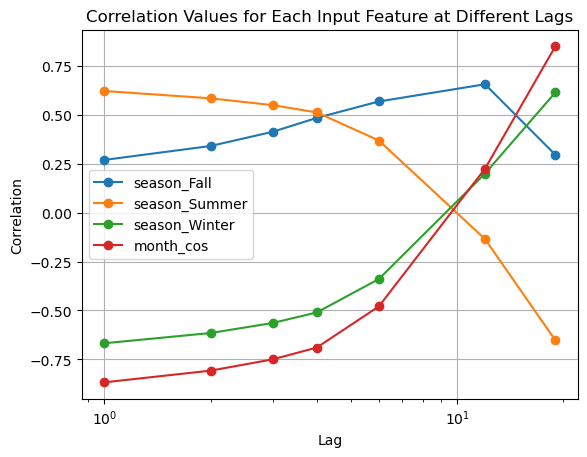

In [170]:
# Calculate the correlation between each input feature and the target variable at different lags
correlation_values = {}

for feature in df_final.columns:
    if feature != 'AverageTemperature' and feature != 'AverageTemperatureChangeVsLastMonth':
        correlation_values[feature] = []
        for lag in factors_of_num:
            correlation = df_final[feature].corr(df_final['AverageTemperature'].shift(lag))
            correlation_values[feature].append(correlation)

# Filter out features with low correlation values
correlation_values = {feature: correlations for feature, correlations in correlation_values.items() if max(correlations) > 0.5}

# Plot the correlation values for each input feature at different lags
for feature, correlations in correlation_values.items():
    plt.plot(factors_of_num, correlations, label=feature, marker='o')

plt.xlabel('Lag')
plt.xscale('log')
plt.ylabel('Correlation')
plt.title('Correlation Values for Each Input Feature at Different Lags')
plt.grid(True)
plt.legend()
plt.show()

In [243]:
test_size = int(0.2*df_final.shape[0])
split_index = df_final.shape[0] - test_size

# Split the data
train_data = df_final.iloc[:split_index]
test_data = df_final.iloc[split_index:]

X_train = train_data.drop(columns=['AverageTemperature'])
y_train = train_data['AverageTemperature']
X_test = test_data.drop(columns=['AverageTemperature'])
y_test = test_data['AverageTemperature']

models = {'LinearRegressor': [LinearRegression()], 
          'Lasso': [Lasso()], 
          'RandomForest': [RandomForestRegressor()], 
          'GradientBoosting': [GradientBoostingRegressor()], 
          'AdaBoost': [AdaBoostRegressor()]
          }

for key, values in models.items():
    model = values[0]
    model.fit(X_train, y_train)

    # Make predictions for both training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate on the training set
    train_rmse = np.sqrt(mean_squared_error(y_train.to_numpy(), y_train_pred))
    train_r2 = r2_score(y_train.to_numpy(), y_train_pred)

    # Evaluate on the testing set
    test_rmse = np.sqrt(mean_squared_error(y_test.to_numpy(), y_test_pred))
    test_r2 = r2_score(y_test.to_numpy(), y_test_pred)

    values.extend([train_rmse, train_r2, test_rmse, test_r2])

    print(key)
    print('\bMetrics: ')
    print(f'Training set RMSE: {values[1]},    Training set R^2 Score: {values[2]}')
    print(f'Testing set RMSE: {values[3]},     Testing set R^2 score: {values[4]}')
    print()



LinearRegressor
Metrics: 
Training set RMSE: 0.5551056864622921,    Training set R^2 Score: 0.9834656878331419
Testing set RMSE: 0.4982368503818536,     Testing set R^2 score: 0.9863136188385851

Lasso
Metrics: 
Training set RMSE: 2.0800755183604323,    Training set R^2 Score: 0.7678370115373924
Testing set RMSE: 2.150035603269187,     Testing set R^2 score: 0.7451361478043719

RandomForest
Metrics: 
Training set RMSE: 0.039086106436184695,    Training set R^2 Score: 0.9999180253443504
Testing set RMSE: 0.17202423658812135,     Testing set R^2 score: 0.9983684656633469

GradientBoosting
Metrics: 
Training set RMSE: 0.3337877172563081,    Training set R^2 Score: 0.994021730580967
Testing set RMSE: 0.4874694738969503,     Testing set R^2 score: 0.9868987785019177

AdaBoost
Metrics: 
Training set RMSE: 0.9036804418085872,    Training set R^2 Score: 0.9561807897134232
Testing set RMSE: 1.0905957790408731,     Testing set R^2 score: 0.9344240539474887



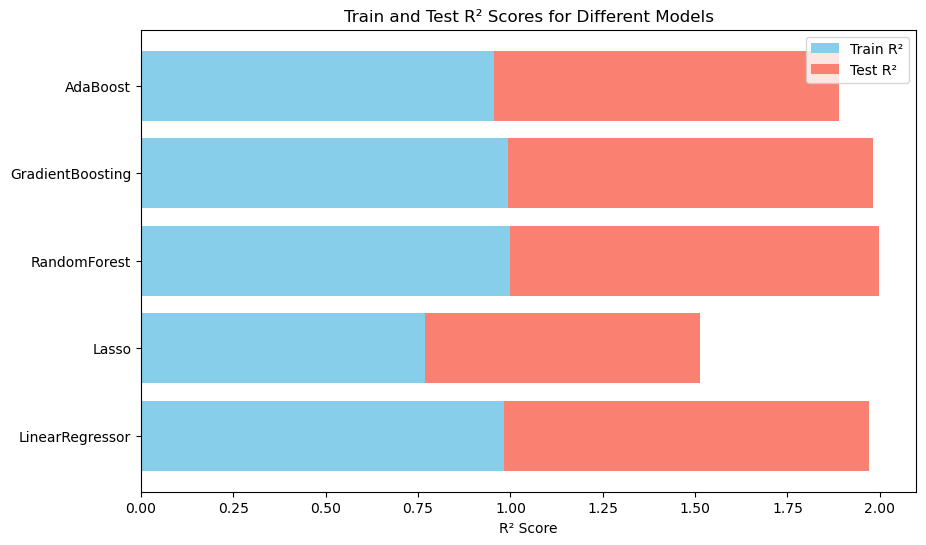

In [244]:
train_r2_scores = [i[2] for i in models.values()]
test_r2_scores = [j[4] for j in models.values()]

plt.figure(figsize=(10, 6))
plt.barh(models.keys(), train_r2_scores, color='skyblue', label='Train R²')
plt.barh(models.keys(), test_r2_scores, left=train_r2_scores, color='salmon', label='Test R²')
plt.xlabel('R² Score')
plt.title('Train and Test R² Scores for Different Models')
plt.legend()
plt.show()